<a href="https://colab.research.google.com/github/Wei-ChenLee/MARL_project/blob/master/Base_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classes

The classes Agent and Game are defined.

In [1]:
from collections import defaultdict
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import random

#random.seed(1)

class Agent:
    def __init__(self, idx, signals, actions, 
                 epsilon = 0.5, epsilon_decay = 0.997, 
                 learn_rate = 0.3, learn_rate_decay = 1,
                 disc_factor = 0.9):
        self.records = defaultdict(list)
        self.epsilon = epsilon
        self.learn_rate = learn_rate
        self.disc_factor = disc_factor
        self.idx = idx
        self.signals = signals
        self.actions = actions
        self.parameters = {'init_epsilon': epsilon,
                           'epsilon_decay': epsilon_decay,
                           'init_learn_rate': learn_rate,
                           'learn_rate_decay': learn_rate_decay,
                           'disc_factor': disc_factor}
        
        # Build q-table using signals and actions
        # First key identifies signal; second key identifies the action given signal
        self.q_values = dict()
        for s in signals:
            self.q_values[s] = dict()
            #for a in actions[s][idx]:
            for a in actions[s]:
                self.q_values[s][a] = random.random()*0.1

    def choose_action(self, signal):
        # Determine whether to explore or exploit
        if random.random() < self.epsilon:
            # Explore, choose random action
            self.records['explore'].append(1)
            act = random.choice(list(self.q_values[signal]))   
            print('Player', self.idx, 'explores, chooses action', act)
     
        else:
            # Exploit, choose optimal action
            mode = 'exploits'
            self.records['explore'].append(0)
            act, value = 0, -1
            for a in self.q_values[signal].keys():
                if self.q_values[signal][a] >= value:
                    act = a
                    value = self.q_values[signal][a]       
            print('Player', self.idx, 'exploits, chooses action', act)

        # Record
        self.records['act'].append(act)

        # Return chosen action
        return act

    def update_q(self, signal_current, act, reward, signal_next):
        for s in self.signals:
            for a in self.actions[s]:
                self.records[s+", "+a].append(self.q_values[s][a])

        self.q_values[signal_current][act] = \
            (1-self.learn_rate) * self.q_values[signal_current][act] + \
            self.learn_rate * (reward + self.disc_factor * 
                               max(self.q_values[signal_next].values()))    
        print(self.q_values)   

    def update_e(self):
        # Record current epsilon and learn_rate
        self.records['epsilon'].append(self.epsilon)
        self.records['learn_rate'].append(self.learn_rate)

        # Update epsilon and learn_rate
        self.epsilon *= self.parameters['epsilon_decay']
        self.learn_rate *= self.parameters['learn_rate_decay']

    def print_q(self):
        for s in list(self.q_values):
            for a in list(self.q_values[s]):
                print ("("+s+", "+a+"): "+str(self.q_values[s][a]))

    def reset(self):
        # Reset agent (without creating a new instance)
        for s in list(self.q_values):
            for a in list(self.q_values[s]):
                self.q_values[s][a] = random.random()*0.1
        self.epsilon = self.parameters['init_epsilon']
        self.learn_rate = self.parameters['init_learn_rate']
        self.records = defaultdict(list)

class Game:

    def __init__(self, model):
        self.states = model.states
        self.transition_matrix = model.transition_matrix
        self.players = model.players
        self.state_signal = model.state_signal
        self.action_space = model.action_space
        self.rewards = model.rewards
        self.num_of_players = len(model.players)

    def state_transition(self, state, action):
        return self.transition_matrix[(state, action)]

    def state_to_signal(self, state, player_idx):
        return self.state_signal[state][player_idx]

    def return_rewards(self, state, action):
        return self.rewards[(state, action)]

    def play_stage_game(self, state):     
        ''' Run through the stage game once. Players update  '''
        # Aggregate actions given state
        actions = []
        for idx in range(self.num_of_players):
            signal = self.state_to_signal(state, idx)
            actions.append(self.players[idx].choose_action(signal))
        actions = tuple(actions)

        # Determine reward and next state, given current state and actions
        r = self.return_rewards(state, actions)
        state_next = self.state_transition(state, actions)

        # Print out info
        print('State', state)
        print('Actions', actions)
        print('Rewards', r)

        # Players update action values and epsilon
        for idx in range(self.num_of_players):
            self.players[idx].update_q(self.state_to_signal(state, idx), 
                                       actions[idx], r[idx], 
                                       self.state_to_signal(state_next, idx))
            self.players[idx].update_e()

        # Update game state
        self.state = state_next

    def play(self, initial_state = None, iterations = 2000):
        ''' Plays stage game a number of times. Print out q-values at end. '''

        # Determine iniitial state
        if initial_state == None:
            self.state = random.choice(self.states)
        else: 
            self.state = initial_state
        
        # Reset players
        for p in self.players:
            p.reset()

        # Play stage game a number of times
        for i in range(iterations):
            print('i = ', i+1)
            self.play_stage_game(self.state)
        
        # Output q-values
        for idx in range(self.num_of_players):
            print("Player ", idx+1)
            self.players[idx].print_q()

    def plot_game(self):
        plt.style.use('seaborn-darkgrid')

        num_signals = len(self.players[0].signals)
        num_players = len(self.players)

        fig, axs = plt.subplots(num_signals, num_players, 
                                figsize=(6*num_players, 3.5*num_signals))
        fig.subplots_adjust(hspace = 0.4, wspace= 0.15)
        axs = axs.ravel()

        i = 0
        for u in self.players[0].signals:
            for a in self.players[0].actions[u]:
                for p in self.players:
                    signal_action = u+", "+a
                    axs[i+p.idx].set_title('Player '+str(p.idx) + ", Signal " + u)
                    #axs[i+p.idx].set_xlabel('iterations')
                    axs[i+p.idx].set_ylabel('q value')
                    axs[i+p.idx].plot(p.records[signal_action], label = a)    
            i += num_players

        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc ='lower center', ncol = 2)
        fig.show()




# Models

Define all the models for experimentation. Models can be loaded into a Game instance at initialisation once built. For example, 
```
model = Model(2)
g = Game(model)
```
**Model 1**

Stateless (single state), symmetric two players. Players associate reward only with their own action $a \in \{c,d\}$. Since the state is invariant, action values are learnt for each action.

**Model 2**

Two player symmetric. Players observe two possible signals, equivalent to the action taken by their opponent in the previous stage game. Players associate reward with the previous action of opponent, and their own action in the present stage game. Denoting states with upper-case and actions with lower-case, q-values learnt are $q(C, c), q(C, d), q(D, c), q(D, d)$.

**Model 2.1**

As model 2, but with much higher reward when both players play 'c' (9 compared to 2). Reward for (d,c) becomes (10, 0)

**Model 3**

Two player symmetric. Players observe four possible signals, equivalent to the action taken by themself and their opponent in the previous stage game (i.e. CC, CD, DC, DD). Denoting states with upper-case and actions with lower-case, q-values learnt are $q(CC, c), q(CC, d), q(DD, c), q(DD, d), q(CD, c), q(CD, d), q(DC, c), q(DC, d)$.

**Model 3.1**

As model 3, but with much higher reward when both players play 'c' (9 compared to 2). Reward for (d,c) becomes (10, 0)

**Model 4**














In [ ]:
class Model:

    def build_m1(self):
        self.states = ['s0']
        self.transition_matrix = {}
        for action in (('c', 'c'), ('d', 'd'), ('c', 'd'), ('d', 'c')):
            self.transition_matrix[('s0', action)] = 's0'

        self.signals = ['u0']
        self.action_space = {}
        self.action_space['u0'] = ('c', 'd')

        p0 = Agent(0, self.signals, self.action_space)
        p1 = Agent(1, self.signals, self.action_space)
        self.players = (p0, p1)

        self.state_signal = {}
        self.state_signal['s0'] = ('u0', 'u0')

        self.rewards = {}
        self.rewards[('s0', ('c', 'c'))] = (2, 2)
        self.rewards[('s0', ('d', 'd'))] = (1, 1)
        self.rewards[('s0', ('c', 'd'))] = (0, 3)
        self.rewards[('s0', ('d', 'c'))] = (3, 0)

    def build_m2(self):
        self.states = ['DD', 'CD', 'DC', 'CC']
        self.transition_matrix = {}
        for s in self.states:
            for action in (('c', 'c'), ('d', 'd'), ('c', 'd'), ('d', 'c')):
                new_state = (action[0]+action[1]).upper()
                self.transition_matrix[(s, action)] = new_state

        # Signals: the signal space that each player can observe
        # Action space: specifies the actions available (to all players) for a given signal
        self.signals = ['C', 'D']
        self.action_space = {}
        for u in self.signals:
            self.action_space[u] = ('c', 'd')
        p0 = Agent(0, self.signals, self.action_space)
        p1 = Agent(1, self.signals, self.action_space)
        self.players = (p0, p1)

        # State to signal mapping: the signal to player i is the previous action of player j 
        self.state_signal = {}
        for s in self.states:
            self.state_signal[s] = (s[1], s[0])

        self.rewards = {}
        for s in self.states:
            self.rewards[(s, ('c', 'c'))] = (2, 2)
            self.rewards[(s, ('d', 'd'))] = (1, 1)
            self.rewards[(s, ('c', 'd'))] = (0, 3)
            self.rewards[(s, ('d', 'c'))] = (3, 0)

    def build_m2_1(self):
        self.build_m2()
        for s in self.states:
            self.rewards[(s, ('c', 'c'))] = (9, 9)
            self.rewards[(s, ('d', 'd'))] = (1, 1)
            self.rewards[(s, ('c', 'd'))] = (0, 10)
            self.rewards[(s, ('d', 'c'))] = (10, 0)

    
    def build_m3(self):
        self.states = ['DD', 'CD', 'DC', 'CC']
        self.transition_matrix = {}
        for s in self.states:
            for action in (('c', 'c'), ('d', 'd'), ('c', 'd'), ('d', 'c')):
                new_state = (action[0]+action[1]).upper()
                self.transition_matrix[(s, action)] = new_state

        # Signals: the signal space that each player can observe
        # Action space: specifies the actions available (to all players) for a given signal
        self.signals = self.states
        self.action_space = {}
        for u in self.signals:
            self.action_space[u] = ('c', 'd')
        p0 = Agent(0, self.signals, self.action_space)
        p1 = Agent(1, self.signals, self.action_space)
        self.players = (p0, p1)

        # State to signal mapping: both players observe true state (previous play) 
        self.state_signal = {}
        for s in self.states:
            self.state_signal[s] = (s, s)

        self.rewards = {}
        for s in self.states:
            self.rewards[(s, ('c', 'c'))] = (2, 2)
            self.rewards[(s, ('d', 'd'))] = (1, 1)
            self.rewards[(s, ('c', 'd'))] = (0, 3)
            self.rewards[(s, ('d', 'c'))] = (3, 0)

    def build_m3_1(self):
        self.build_m3()
        for s in self.states:
            self.rewards[(s, ('c', 'c'))] = (9, 9)
            self.rewards[(s, ('d', 'd'))] = (1, 1)
            self.rewards[(s, ('c', 'd'))] = (0, 10)
            self.rewards[(s, ('d', 'c'))] = (10, 0)

    def build_m4(self):
        ''' Players first send each other signals. Then, having observed signal, decide
        on actions. Reward is given. Repeat. Players have no memory of previous stage
        games, only the signal observed in the present game. 
        
        Modelled as game of 4 states (2 signals per player). Signal space for each player
        is 2. 
        '''
        self.states = ['DD', 'CD', 'DC', 'CC']
        self.transition_matrix = {}
        for s in self.states:
            for action in (('c', 'c'), ('d', 'd'), ('c', 'd'), ('d', 'c')):
                new_state = (action[0]+action[1]).upper()
                self.transition_matrix[(s, action)] = new_state

        # Signals: the signal space that each player can observe
        # Action space: specifies the actions available (to all players) for a given signal
        self.signals = self.states
        self.action_space = {}
        for u in self.signals:
            self.action_space[u] = ('c', 'd')
        p0 = Agent(0, self.signals, self.action_space)
        p1 = Agent(1, self.signals, self.action_space)
        self.players = (p0, p1)

        # State to signal mapping: both players observe true state (previous play) 
        self.state_signal = {}
        for s in self.states:
            self.state_signal[s] = (s, s)

        self.rewards = {}
        for s in self.states:
            self.rewards[(s, ('c', 'c'))] = (2, 2)
            self.rewards[(s, ('d', 'd'))] = (1, 1)
            self.rewards[(s, ('c', 'd'))] = (0, 3)
            self.rewards[(s, ('d', 'c'))] = (3, 0)


    def __init__(self, model_code):
        switcher = {
            1: self.build_m1,
            2: self.build_m2,
            2.1: self.build_m2_1,
            3: self.build_m3,
            3.1: self.build_m3_1,
            4: self.build_m4,
        }
        build_model = switcher.get(model_code, 
                                   print('WL: Not a valid model code'))
        build_model()



# Run model

Streaming output truncated to the last 5000 lines.
State CC
Actions ('d', 'd')
Rewards (1, 1)
{'DD': {'c': 51.97850635093384, 'd': 38.310649092166905}, 'CD': {'c': 18.3486078767544, 'd': 49.395043906439824}, 'DC': {'c': 26.95257750448958, 'd': 45.128334993789096}, 'CC': {'c': 21.300463779505186, 'd': 47.77020061625338}}
{'DD': {'c': 52.07103739156118, 'd': 34.9847757350792}, 'CD': {'c': 37.7827374879926, 'd': 25.71899504969583}, 'DC': {'c': 15.486394873909315, 'd': 46.11979476565246}, 'CC': {'c': 24.450037673690588, 'd': 47.86111065769543}}
i =  1379
Player 0 exploits, chooses action c
Player 1 exploits, chooses action c
State DD
Actions ('c', 'c')
Rewards (9, 9)
{'DD': {'c': 51.982908612042095, 'd': 38.310649092166905}, 'CD': {'c': 18.3486078767544, 'd': 49.395043906439824}, 'DC': {'c': 26.95257750448958, 'd': 45.128334993789096}, 'CC': {'c': 21.300463779505186, 'd': 47.77020061625338}}
{'DD': {'c': 52.07222605167059, 'd': 34.9847757350792}, 'CD': {'c': 37.7827374879926, 'd': 25.71899

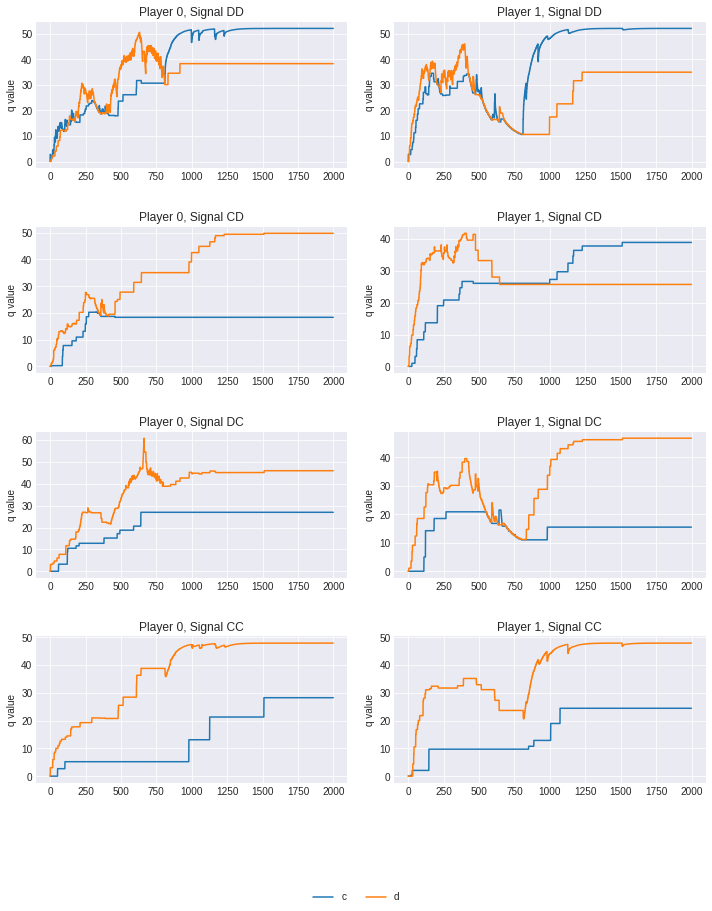

In [ ]:
model = Model(3.1)

g = Game(model)
g.play()

g.plot_game()
# p0.records

In [ ]:
#plot_m2()

g.players[0].actions['C']

('c', 'd')